In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la

import seaborn as sn
import matplotlib.font_manager as fm

font_path = "/Users/pedrobraga/Documents/Cambridge/wa_two/cmunci.ttf"
custom_font = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = custom_font.get_name()
sn.set(font=custom_font.get_name())

sn.set_theme(context='notebook', style='whitegrid', palette='rocket_r', font_scale=1, color_codes=True, rc=None)

In [287]:
# --- import eigenvalues and eigenvectors calculated previously --- #

eigenvalues = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvalues5.txt')
eigenvectors = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvectors5.txt')

In [288]:
# --- global variables --- #

hbar = 0.658 # eV fs
m0 = 5.6856800 # fs2 eV/nm2
mu = 0.108 * m0 # fs2 eV/nm2
kb = 8.681e-4 # ev K {-1}

veps0 = 5.52638e-2 # c{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
A = Lwell**2 # nm{2}
r0 = Lwell * vepsW/(2*vepsS) # nm

EgZero = 2.565 # ev - zero temperature bandgap energy
n = 1.82 # dimless - refractive index of the medium 
M = 0.44 * m0 # fs2 eV/nm2 - total exciton mass
Msigma = 8 # fs ev nm{-1} - optical matrix element for interband transition
GammaZero = 0.0067 # eV - defect-induced line widgth at T = 0K

DAC = 1.9 # eV - deformation potential for acoustic phonons
DOP = 158 # eV/nm - deformation potential for optical phonons

cAC = 2100 # m/s - acoustic phonon charactetistic velocity
c0 = 299.792 # nm/fs - speed of light in vacuum
hwOP = 35 # meV - optical phonon scattering

alphaOne = 1e-4 # material specific constant for Varshni shift
alphaTwo = 340 # material specific constant for Varshni shift

# --- simulation variables --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)
energies = np.linspace(-2, 3, 10000)

In [289]:
def BandGapEnergy(mu):
    return EgZero + eigenvalues[mu]

def RadiativeRecom(mu, eigenvalues, eigenvectors): # Temperature independent radiactive recombination of eletrons
    wavefunction = FFT(mu, eigenvectors)
    C = (hbar**2 * Msigma**2) / (2 * m0**2 * veps0 * A * n * c0)

    return C * wavefunction / eigenvalues[mu]

def FFT(mu, eigenvectors): # inverse fourier transform of the amplitude of the wavefunctions
    C = A * dk / (2*np.pi)
    integral = np.sum(eigenvectors[mu][-500:] * k_vals)

    return (C * integral)**2

def Boltzmann(T, mu, eigenvalues):
    ZVec = np.sum(np.exp(eigenvalues/(kb*T)))
    BVec = np.exp(eigenvalues[mu]/(kb*T))/ZVec

    return BVec

In [291]:
for i in [0,1,2,3,4]:
    print((RadiativeRecom(i, eigenvalues, eigenvectors)))

0.0012217210318582288
0.0003673592396687041
0.00022493898524924785
0.00016508154810161046
0.00013141522619413492


In [292]:
for i in [0,1,2,3,4]:
    print((RadiativeRecom(i, eigenvalues, eigenvectors) + GammaZero)**2)

6.2753664106585e-05
4.994756662253061e-05
4.7954779949424885e-05
4.7129344662085204e-05
4.666823399267706e-05


In [293]:
for i in [0,1,2,3,4]:
    print(BandGapEnergy(i))

2.73236242
2.6002159575
2.5800097982
2.573214079
2.570131892


In [294]:
def Photoluminescence(energy_range, T, eigenvalues, eigenvectors):

    PL = []
    C = 2 * Msigma**2 / hbar

    for E in energy_range:
        I = 0

        for mu in range(len(eigenvalues)):

            B = FFT(mu, eigenvectors) * RadiativeRecom(mu, eigenvalues, eigenvectors) * Boltzmann(T, mu, eigenvalues)
            denominator = (BandGapEnergy(mu) - E)**2 + (RadiativeRecom(mu, eigenvalues, eigenvectors) + GammaZero)**2
            I += B/denominator

        PL.append(C*I)

    return PL

In [295]:
PL300 = Photoluminescence(energies, 300, eigenvalues, eigenvectors)
PL200 = Photoluminescence(energies, 200, eigenvalues, eigenvectors)
PL100 = Photoluminescence(energies, 100, eigenvalues, eigenvectors)
PL50 = Photoluminescence(energies, 50, eigenvalues, eigenvectors)
PL10 = Photoluminescence(energies, 10, eigenvalues, eigenvectors)

In [312]:
max(PL10)

np.float64(22.032885532381822)

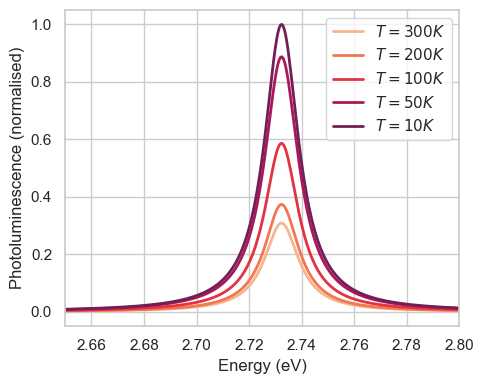

In [324]:
fig = plt.figure(figsize=(5,4))
plt.plot(energies, np.array(PL300)/22.032885532381822, label='$T = 300 K$', linewidth=2)
plt.plot(energies, np.array(PL200)/22.032885532381822, label='$T = 200 K$', linewidth=2)
plt.plot(energies, np.array(PL100)/22.032885532381822, label='$T = 100 K$', linewidth=2)
plt.plot(energies, np.array(PL50)/22.032885532381822, label='$T = 50 K$', linewidth=2)
plt.plot(energies, np.array(PL10)/22.032885532381822, label='$T = 10 K$', linewidth=2)
plt.xlabel('Energy (eV)')
plt.ylabel('Photoluminescence (normalised)')
plt.xlim(2.65, 2.8)

plt.tight_layout()
plt.legend()
plt.savefig('PL.pdf', dpi=600)